In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
!pip install catboost

In [2]:
df_catboost = pd.read_csv('fraud_data_notencoded.csv')

In [3]:
X = df_catboost.drop(columns=['is_fraud'])
y = df_catboost['is_fraud']

# Split for CatBoost
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
# Ratio of negative to positive class
scale_pos_weightx = len(y_train_cat[y_train_cat == 0]) / len(y_train_cat[y_train_cat == 1])

In [5]:
# List of categorical features (CatBoost handles them automatically)
cat_features = [
    'merchant_category', 'merchant_type', 'country', 'merchant',
    'card_type', 'card_present', 'high_risk_merchant', 'weekend_transaction'
]

# Train CatBoost
model_cat = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    scale_pos_weight=scale_pos_weightx,
    eval_metric='AUC',
    cat_features=cat_features,
    verbose=100,
    random_seed=42
)

model_cat.fit(X_train_cat, y_train_cat,
              eval_set=(X_test_cat, y_test_cat),
              early_stopping_rounds=50)

# Predict and evaluate CatBoost
y_pred_cat = model_cat.predict(X_test_cat)
y_proba_cat = model_cat.predict_proba(X_test_cat)[:, 1]

0:	test: 0.9771104	best: 0.9771104 (0)	total: 8.98s	remaining: 29m 47s
100:	test: 0.9909841	best: 0.9909841 (100)	total: 10m 46s	remaining: 10m 33s
199:	test: 0.9943515	best: 0.9943515 (199)	total: 21m 31s	remaining: 0us

bestTest = 0.9943515019
bestIteration = 199




CatBoost Results:


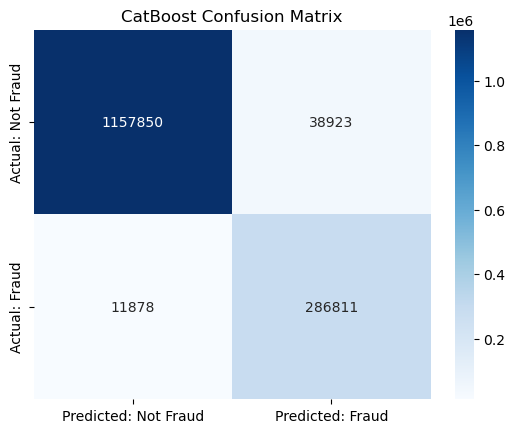


Classification Report (CatBoost):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.97      0.98   1196773
       Fraud       0.88      0.96      0.92    298689

    accuracy                           0.97   1495462
   macro avg       0.94      0.96      0.95   1495462
weighted avg       0.97      0.97      0.97   1495462

ROC AUC Score (CatBoost): 0.994352


In [6]:
# Evaluate CatBoost
print("\nCatBoost Results:")
cm_cat = confusion_matrix(y_test_cat, y_pred_cat)

sns.heatmap(pd.DataFrame(cm_cat, index=['Actual: Not Fraud', 'Actual: Fraud'],
                         columns=['Predicted: Not Fraud', 'Predicted: Fraud']),
            annot=True, fmt='d', cmap='Blues')
plt.title("CatBoost Confusion Matrix")
plt.show()

print("\nClassification Report (CatBoost):")
print(classification_report(y_test_cat, y_pred_cat, target_names=['Not Fraud', 'Fraud']))
print(f"ROC AUC Score (CatBoost): {roc_auc_score(y_test_cat, y_proba_cat):.6f}")

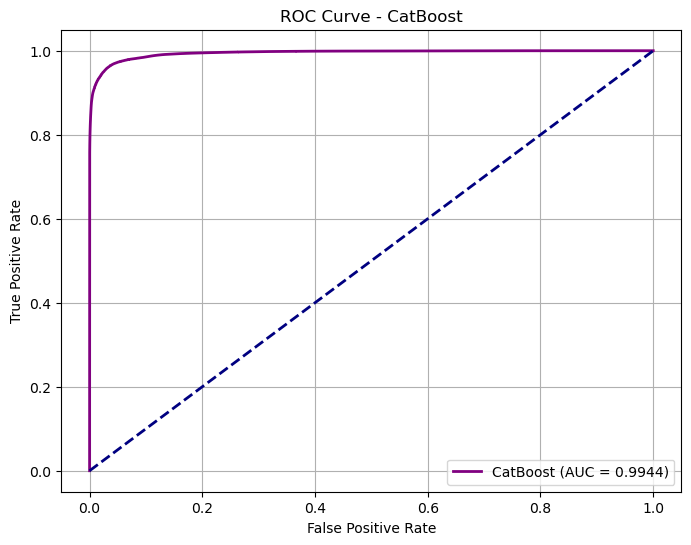

In [7]:
from sklearn.metrics import roc_curve, auc

# ROC for CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_test_cat, y_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cat, tpr_cat, color='purple', lw=2,
         label=f'CatBoost (AUC = {roc_auc_cat:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [5]:
!pip install lightgbm

In [6]:
import lightgbm as lgb

In [7]:
# List of your categorical string columns
cat_columns = ['merchant_category', 'merchant_type', 'country', 'merchant',
               'card_type', 'card_present', 'high_risk_merchant', 'weekend_transaction']

# Convert to category dtype
for col in cat_columns:
    df_catboost[col] = df_catboost[col].astype('category')

# Split data
X = df_catboost.drop(columns='is_fraud')
y = df_catboost['is_fraud']

from sklearn.model_selection import train_test_split
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM model
model_lgb = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    class_weight='balanced'
)

# Train the model
model_lgb.fit(X_train_lgb, y_train_lgb, categorical_feature=cat_columns)

# Predict
y_pred_lgb = model_lgb.predict(X_test_lgb)
y_proba_lgb = model_lgb.predict_proba(X_test_lgb)[:, 1]

[LightGBM] [Info] Number of positive: 1194226, number of negative: 4787618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 5981844, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000



LightGBM Results:


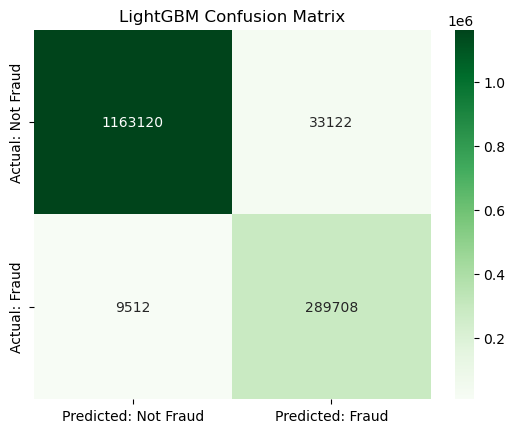


Classification Report (LightGBM):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.97      0.98   1196242
       Fraud       0.90      0.97      0.93    299220

    accuracy                           0.97   1495462
   macro avg       0.94      0.97      0.96   1495462
weighted avg       0.97      0.97      0.97   1495462

ROC AUC Score (LightGBM): 0.996184


In [8]:
print("\nLightGBM Results:")
cm = confusion_matrix(y_test_lgb, y_pred_lgb)
sns.heatmap(pd.DataFrame(cm, index=['Actual: Not Fraud', 'Actual: Fraud'],
                         columns=['Predicted: Not Fraud', 'Predicted: Fraud']),
            annot=True, fmt='d', cmap='Greens')
plt.title("LightGBM Confusion Matrix")
plt.show()

print("\nClassification Report (LightGBM):")
print(classification_report(y_test_lgb, y_pred_lgb, target_names=['Not Fraud', 'Fraud']))
print(f"ROC AUC Score (LightGBM): {roc_auc_score(y_test_lgb, y_proba_lgb):.6f}")

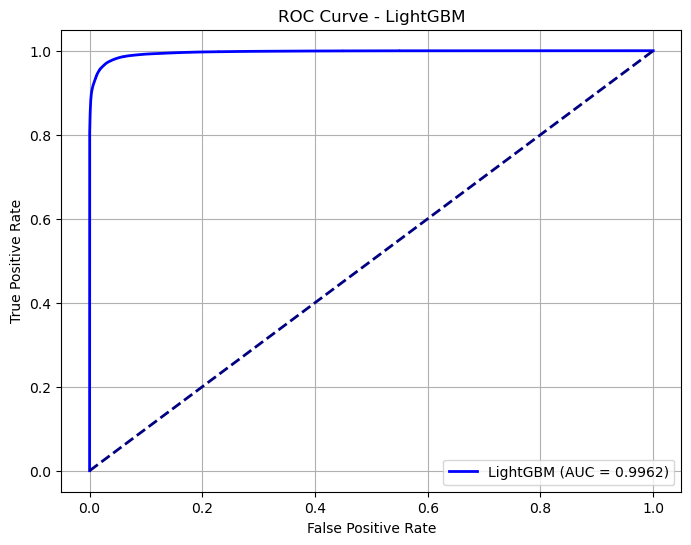

In [10]:
# ROC for LightGBM
from sklearn.metrics import roc_curve, auc
fpr_lgb, tpr_lgb, _ = roc_curve(y_test_lgb, y_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, color='blue', lw=2,
         label=f'LightGBM (AUC = {roc_auc_lgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc="lower right")
plt.grid()
plt.show()